Compare output from dask streaming analysis to results from Fluctana.

We calculate results from RMCs examples/nersc/check_correlation.py for Channels L1102 and L0906 to
results from the streaming analysis package.


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import adios2

In [15]:
# Run the fluctana code from RMCs examples/nersc/check_correlation.py

cfg =  None
self.fname =  /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L1102, ref = 100%, siglevel = 0.0001 V
cfg =  None
self.fname =  /global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/ECEI.018431.LFS.h5
Rading init: 
Data is normalized by trange average ECEI
LOW signal level channel ECEI_L0906, ref = 100%, siglevel = 0 V
***fftbins: win_factor = 0.374268
dnum 0 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1
***fftbins: win_factor = 0.374268
dnum 1 fftbins 37 with hann size 512 overlap 0.5 detrend 0 full 1


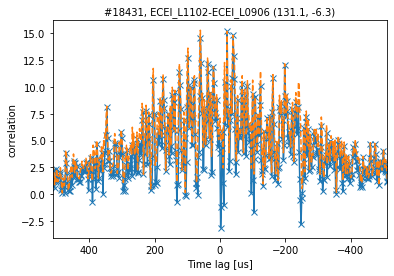

In [68]:
def test_rmc():
    import sys
    sys.path.append("/global/homes/r/rkube/repos/fluctana_rmc")
    from fluctana import FluctAna, KstarEcei

    shot = 18431
    trange = [-0.12, -0.10]
    clist = [['ECEI_L1102'], ['ECEI_L0906']]

    # call fluctana
    A = FluctAna()

    # add data
    A.add_data(KstarEcei(shot=shot, clist=clist[0], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)
    A.add_data(KstarEcei(shot=shot, clist=clist[1], data_path='/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/'), trange=trange, norm=1)

    # do fft; full = 1 
    A.fftbins(nfft=512, window='hann', overlap=0.5, detrend=0, full=1)

    # calculate correlation using data sets done and dtwo. results are saved in A.Dlist[dtwo].val
    A.correlation(done=0, dtwo=1)

    # plot the results; dnum = data set number, cnl = channel number list to plot
    A.mplot(dnum=1,cnl=range(len(A.Dlist[1].clist)),type='val')
    
    return(A)
A = test_rmc()

In [89]:
A.Dlist[0].spdata.shape

(1, 37, 513)

In [94]:
plt.plot(np.abs(A.Dlist[2].spdata[0,:,:].mean(axis=0)))
plt.plot(np.fft.fftshift(np.abs(fft_data[81, :, :].mean(axis=1))))

IndexError: list index out of range

In [100]:
dir(A.Dlist[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apos',
 'ax',
 'beam_path',
 'bins',
 'channel_position',
 'clist',
 'cnidx1',
 'data',
 'data_path',
 'detrend',
 'dev',
 'find_bad_channel',
 'fname',
 'fs',
 'get_abcd',
 'get_data',
 'good_channels',
 'hn',
 'itf',
 'lo',
 'mode',
 'nfft',
 'offlev',
 'offstd',
 'overlap',
 'read_init',
 'rpos',
 'sf',
 'shot',
 'show_ch_position',
 'siglev',
 'sigstd',
 'spdata',
 'sz',
 'time',
 'time_base',
 'time_base_full',
 'toff',
 'trange',
 'tt',
 'win_factor',
 'window',
 'zpos']

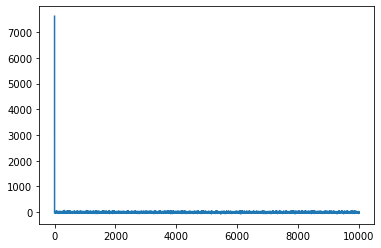

In [49]:
L1102_fa = np.squeeze(A.Dlist[0].data)
plt.plot(L1102_fa)

In [69]:
with np.load("../ralphs_task_000.npz") as df:
    res_dask = df["res"]
    
with np.load("../io_array_s0000.npz") as df:
    io_array = df["io_array"]

with np.load("../io_array_tr_s0000.npz") as df:
    io_array_tr = df["io_array"]

with np.load("../offset_lvl.npz") as df:
    offset_lvl = df["offset_lvl"]
    
with np.load("../fft_data_s0000.npz") as df:
    fft_data = df["fft_data"]

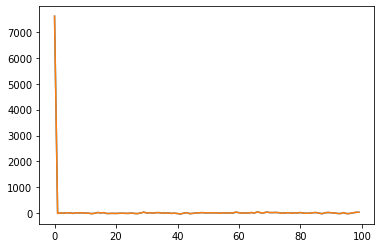

In [60]:
plt.plot(io_array_tr[81,:100])
plt.plot(L1102_fa[:100])

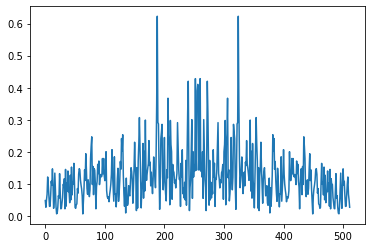

In [75]:
plt.plot(np.fft.fftshift(np.abs(fft_data[81, :, :].mean(axis=1))))

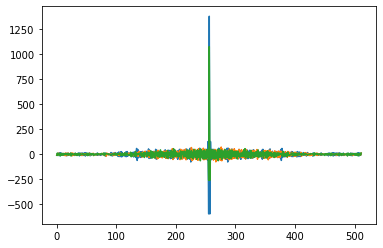

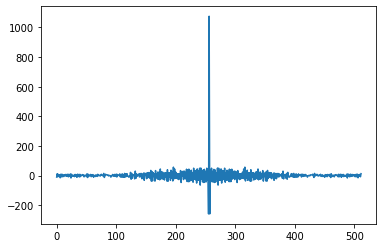

In [86]:
plt.plot(res_dask[2,:])

In [36]:
print(stream_data[0,:4])
print(L1102_fa[:4])

[879.63503347   2.13962443  -3.72495705 -14.50630887]
[ 4.5356e+00 -6.6000e-03  1.9000e-03 -1.8000e-03]


In [31]:
fname = "/global/cscratch1/sd/rkube/KSTAR/kstar_streaming/018431/KSTAR_018431_f32.bp"

ECEI_L1102 = []
ECEI_L0906 = []

with adios2.open(fname, "r") as fh:
    for fstep in fh:
        # print variables information
        step_vars = fstep.available_variables()
        
        if fh.current_step() > 5:
            break
        
        
        ECEI_L1102.append(fstep.read("ECEI_L1102"))
        ECEI_L0906.append(fstep.read("ECEI_L0906"))
 
ECEI_L1102 = np.array(ECEI_L1102)
ECEI_L0906 = np.array(ECEI_L0906)

array([[ 25029., -20393., -20308., ..., -20447., -20211., -20478.],
       [-20397., -20497., -20291., ..., -20317., -20397., -20372.],
       [-20459., -20448., -20402., ..., -19838., -19718., -19692.],
       [-19809., -19781., -19798., ..., -20393., -20355., -20193.],
       [-20383., -20263., -20121., ..., -20048., -20079., -20230.],
       [-20123., -20290., -20366., ..., -20288., -20354., -20243.]],
      dtype=float32)

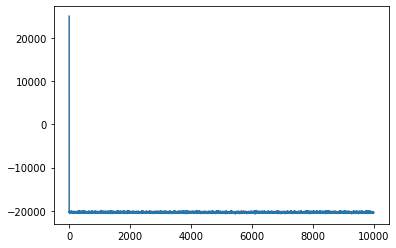

In [33]:
plt.plot(ECEI_L1102[0,:])